In [3]:
#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
from tqdm import tqdm
import statsmodels.api as sm
# import tqdm pandas
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

In [52]:
video_data = pd.read_csv('./yt_tech_channels_metadata.tsv.gz', compression='infer', sep='\t')
video_data = video_data[video_data.tech_review]
channel_data = pd.read_csv('./tech_review_channels.tsv.gz', compression='infer', sep='\t')

In [53]:
def merge_dfs(video_data, channel_data):
    merged = pd.merge(channel_data, video_data, on='channel_id', how='inner')
    return merged

In [54]:
#merge the 2 dataframes to get both the view count and subscriber rank in one dataframe
merged_df = merge_dfs(video_data, channel_data)

We choose the view count as our metric, as a title is intended to attract users to click on our video but there is also the video's thumbnail .

In [55]:
#function to select a subset of videos, filtering on number of views the videos got
def select_subset(df, start, end):
    df = df[(df['view_count'] >= start) & (df['view_count'] <= end)]
    return df

In [56]:
#First we select videos that got views between 0 and 100,000 views as we are targeting new/small channels.
#Then we get the sorted df, first by view count, then by subscriber rank both in descending order. Then select the first/top 10% 
#from the df as we want our readers to be the best.
#By doing so we keep the videos that performed well (got many views) and remove the confounder of the channel's power
#(as if a channel is already powerful/successful, no matter the title it chooses for its videos it will get many views
#while our aim is to give advice to new/small channels)
df_subset = select_subset(merged_df, 0, 100000)
df_sorted = df_subset.sort_values(by=['view_count', 'subscriber_rank_sb'], ascending=[False, False])
df_top_1_per_cent = df_sorted.head(int(len(df_sorted)*0.1))

In [57]:
#function to get the sentiment score of a video's title using TextBlob classifier
def get_sentiment(df):
    df['sentiment'] = df['title'].progress_apply(lambda x: TextBlob(str(x)).sentiment[0])
    return df

In [58]:
# perform ols regression on sentiment and view_count
def ols(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    print_model = model.summary()
    print(print_model)
    return model

In [59]:
#get sentiment scores for titles of videos that got between 0 and 100,000 views
df1 = get_sentiment(df_top_1_per_cent)

100%|██████████████████████████████████████████████████████████████████████████| 11851/11851 [00:02<00:00, 4034.12it/s]
C:\Users\Zied\AppData\Local\Temp\ipykernel_4928\2198046105.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['title'].progress_apply(lambda x: TextBlob(str(x)).sentiment[0])


In [60]:
# perform an ols regression on sentiment and view_count (use sentiment scores to predict the view_count)
ols(df1['sentiment'], df1['view_count'])

                            OLS Regression Results                            
Dep. Variable:             view_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.869
Date:                Wed, 20 Dec 2023   Prob (F-statistic):             0.0154
Time:                        12:13:58   Log-Likelihood:            -1.2906e+05
No. Observations:               11851   AIC:                         2.581e+05
Df Residuals:                   11849   BIC:                         2.581e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.379e+04    134.190    549.876      0.0

We see that the sentiment coefficient is positive and statistically significant (p-value less than 0.05). This means the more positive the title is the more views the video gets.

C:\Users\Zied\AppData\Local\Temp\ipykernel_4928\1088557561.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sentiment'])


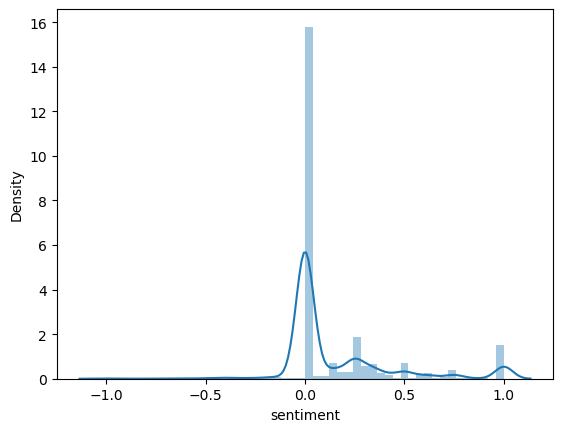

In [61]:
sns.distplot(df1['sentiment'])
plt.show()

We nontheless observe that despite the positive correlation between positive titles and number of views, most "top videos" have neutral titles. 

In [62]:
analyzer = SentimentIntensityAnalyzer()
df1['sentimentV'] = df1['title'].progress_apply(lambda x: analyzer.polarity_scores(x)['compound'])

100%|█████████████████████████████████████████████████████████████████████████| 11851/11851 [00:00<00:00, 18391.02it/s]
C:\Users\Zied\AppData\Local\Temp\ipykernel_4928\4097955033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['sentimentV'] = df1['title'].progress_apply(lambda x: analyzer.polarity_scores(x)['compound'])


In [65]:
# perform an ols regression on sentiment and view_count (use sentiment scores to predict the view_count)
ols(df1['sentimentV'], df1['view_count'])

                            OLS Regression Results                            
Dep. Variable:             view_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.262
Date:                Wed, 20 Dec 2023   Prob (F-statistic):             0.0390
Time:                        12:17:07   Log-Likelihood:            -1.2906e+05
No. Observations:               11851   AIC:                         2.581e+05
Df Residuals:                   11849   BIC:                         2.581e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.384e+04    127.720    578.161      0.0

C:\Users\Zied\AppData\Local\Temp\ipykernel_4928\1897120003.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sentimentV'])


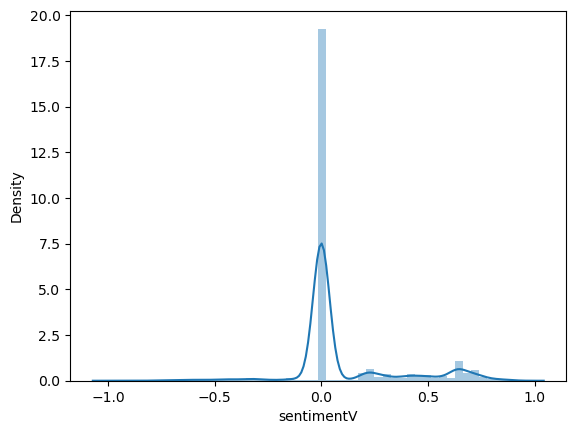

In [64]:
sns.distplot(df1['sentimentV'])
plt.show()

We see the same results in this case when using Vader classifier: positive titles are positively correlated with the number of views, and most titles are neutral. This is not causation as there is also the video's thumbnail that is a confounder that unfortunately we can't match on.